In [74]:
import pandas as pd
import numpy as np
from numpy import vstack
import h5py
import torch
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics 
from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold
from matplotlib import pyplot as plt
from torch import Tensor, nn
from torch.nn import Linear, Sigmoid, ReLU, BCELoss
from torch.optim import SGD
import random
from tqdm import trange 

# Load data

In [2]:
f = h5py.File("pathway_data.h5", "r")

In [3]:
gr_truth = list(f['gr_truth'])

In [4]:
list_inputs = []
for n in trange(len(gr_truth)): 
    arr = np.array(f['sample_' + str(n)])
    list_inputs.append(arr)
X_train, X_test, y_train, y_test = train_test_split(list_inputs, gr_truth, test_size=0.33, random_state=42) 

100%|██████████| 234/234 [03:02<00:00,  1.28it/s]


# Neural network

In [14]:
class LoopNet(nn.Module):
    def __init__(self, shape):
        super(LoopNet, self).__init__()
        self.fc1 = Linear(shape[1], 1)
        self.fc2 = Linear(shape[0], 1)
        self.sigmoid = nn.Sigmoid()

    # x represents our data
    def forward(self, x):
        total = list() 
        for i in range(len(x)): 
            item = torch.from_numpy(x[i])
            y = self.fc1(item) 
            total.append(y)
        total = torch.cat(total, 1)
        total = torch.transpose(total, 0, 1) 
        z = self.sigmoid(self.fc2(total)) 
        return z

In [86]:
# train model 
def train_model(X_train, y_train, model, lr=1e-4, momentum=0.6): 
    # define optimization 
    criterion = BCELoss() 
    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum) 
    # enumerate epochs 
    for epoch in range(100):
        # clear the gradients 
        optimizer.zero_grad()
        # compute the model output 
        yhat = model(X_train) 
        # calculate loss 
        loss = criterion(yhat, y_train)
        # credit assignment 
        loss.backward()
        # update model weights 
        optimizer.step()

def stratifiedKFold(X, y): 
    cv = StratifiedKFold(n_splits=10)
    list_auc = []
    ns_probs = [0 for _ in range(len(X))]
    ns_auc = roc_auc_score(y, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    for train_idx, test_idx in cv.split(X, y): 
        X_train, X_test = [X[i] for i in train_idx], [X[i] for i in test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model = LoopNet(X_train[0].shape)
        train_model(X_train, torch.from_numpy(np.array(y_train)).float(), model)
        lr_auc, lr_fpr, lr_tpr = evaluate_model(X_test, y_test, model, cv=True)
        list_auc.append(lr_auc) 
        plt.plot(lr_fpr, lr_tpr, marker='.')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plot text
    auc_text = "Avg AUC: {:.2f}".format(np.mean(list_auc))
    plt.annotate(auc_text, xy=(1,0), xycoords='axes fraction', textcoords='offset points', ha='right', va='bottom')
    # show the plot
    plt.show()
    return list_auc

def Leave_One_Out(X, y): 
    cv = LeaveOneOut()
    predictions = []
    actuals = []
    labels = []
    for train_idx, test_idx in cv.split(X, y): 
        X_train, X_test = [X[i] for i in train_idx], [X[i] for i in test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model = Net(X_train[0].shape)
        train_model(X_train, np.array(y_train), model)
        for i in trange(len(X_test)):
            inputs = X_test[i]
            targets = torch.from_numpy(y_test[i].astype(np.float32))
            yhat = model(inputs)[0]
            yhat = yhat.detach().numpy()
            predictions += list(yhat)
            actuals += list(targets)
            labels += list(y_test)
    ns_probs = [0 for _ in range(len(predictions))]
    ns_auc = roc_auc_score(y, ns_probs)
    lr_auc = roc_auc_score(actuals, predictions)
    ns_fpr, ns_tpr, _ = roc_curve(labels, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(labels, predictions)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Fully-connected layer')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plot text
    auc_text = "AUC: {:.2f}".format(np.mean(lr_auc))
    plt.annotate(auc_text, xy=(1,0), xycoords='axes fraction', textcoords='offset points', ha='right', va='bottom')
    # show the plot
    plt.show()
        
            
def evaluate_model(X_test, y_test, model, cv=False):
    yhat = model(X_test).detach().numpy()
    predictions, actuals = vstack(yhat), vstack(y_test)
    
    # calculate AUC 
    ns_probs = [0 for _ in range(len(X_test))]
    ns_auc = roc_auc_score(actuals, ns_probs)
    lr_auc = roc_auc_score(actuals, predictions) 
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, predictions)
    
    if cv: return lr_auc, lr_fpr, lr_tpr 
    
    # summarize scores
    print('No skill: ROC AUC=%.3f' % (ns_auc))
    print('Fully-connected layer: ROC AUC=%.3f' % (lr_auc))
    
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Fully-connected layer')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    

def best_lr(X_train, X_test, y_train, y_test): 
    best = 0
    for lr in [1e-5, 1e-4, 1e-3, 1e-2]: 
        for momentum in range(1, 10):
            my_nn = Net(X_train[0].shape)
            train_model(X_train, np.array(y_train), my_nn, lr=lr, momentum=momentum/10)
            lr_auc = evaluate_model(X_test, np.array(y_test), my_nn)
            if lr_auc > best: 
                best = lr_auc
                print(lr_auc)
                print("lr={}".format(lr))
                print("momentum={}".format(momentum))

# Neural network

## Train-test split 

No skill: ROC AUC=0.500
Fully-connected layer: ROC AUC=0.503


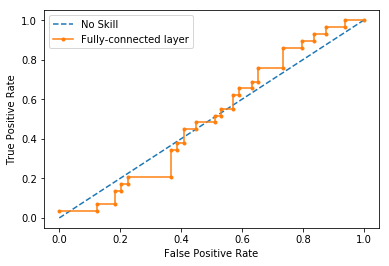

In [79]:
my_nn = LoopNet(X_train[0].shape)
train_model(X_train, torch.from_numpy(np.array(y_train)).float(), my_nn) 
evaluate_model(X_test, np.array(y_test), my_nn) # 1e-4, 0.6

## Stratified k-fold cross validation

/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([209])) that is different to the input size (torch.Size([209, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([210])) that is different to the input size (torch.Size([210, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([211])) that is different to the input size (torch.Size([211, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, targ

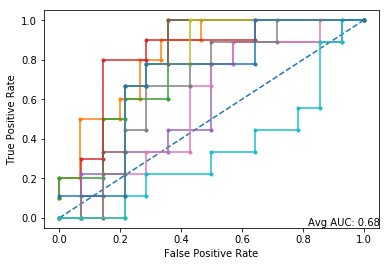

In [87]:
list_aucs = stratifiedKFold(list_inputs, np.array(gr_truth))